# Spoken Language Recognition Using Convolutional Neural Networks

_written by Joscha S. Rieber (Fraunhofer IAIS) in 2020_

## Training Environment

In [1]:
train = 'train'
test = 'test'

eng = 'english'
ger = 'german'
swe = 'swedish'

languages = [eng, ger, swe]
categories = [train, test]

dataset_root_path = '../data/'
train_path = dataset_root_path + train

batch_size = 128
image_width = 500
image_height = 128

validation_split = 0.1
initial_learning_rate = 0.045

num_classes = len(languages)

model_file = dataset_root_path + 'model.h5'

In [3]:
from glob import glob
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# tf.keras.preprocessing.image.ImageDataGenerator
from tensorflow.keras.layers import Input, Concatenate
# tf.keras.layers.Input
# tf.keras.layers.Concatenate
from tensorflow.keras.optimizers import RMSprop
# tf.keras.optimizers.RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
# tf.keras.applications.inception_v3.InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
# tf.keras.callbacks.EarlyStopping
# tf.keras.callbacks.LearningRateScheduler

ModuleNotFoundError: No module named 'tensorflow'

In [4]:
all_files = glob(train_path + '/*/*.png')

num_validation = len(all_files) * validation_split
num_train = len(all_files) - num_validation

validation_steps = int(num_validation / batch_size)
steps_per_epoch = int(num_train / batch_size)

print('Steps per Epoch: ' + str(steps_per_epoch))
print('Validation steps: ' + str(validation_steps))

Steps per Epoch: 19
Validation steps: 2


## Training Batch Generator Function

The following function loads the available images for training, shuffles them and serves them to Keras' training algorithm.

In [5]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=validation_split)
train_generator = image_data_generator.flow_from_directory(train_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale', subset='training')
validation_generator = image_data_generator.flow_from_directory(train_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale', subset='validation')

Found 2508 images belonging to 3 classes.
Found 276 images belonging to 3 classes.


## Model definition

In [6]:
img_input = tf.keras.Input(shape=(image_height, image_width, 1))

img_conc = tf.keras.layers.Concatenate(axis=3, name='input_concat')([img_input, img_input, img_input])

model = tf.keras.applications.inception_v3.InceptionV3(input_tensor=img_conc, weights=None, include_top=True, classes=2)

model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 500, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_concat (Concatenate)     (None, 128, 500, 3)  0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 249, 32)  864         ['input_concat[0][0]']

In [7]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=initial_learning_rate, clipvalue=2.0), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Training

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)

In [9]:
def step_decay(epoch, lr):
    drop = 0.94
    epochs_drop = 2.0
    lrate = lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

learning_rate_decay = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [10]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=60, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, callbacks=[early_stopping, learning_rate_decay])


Epoch 1: LearningRateScheduler setting learning rate to 0.04500000178813934.
Epoch 1/60


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\filip\AppData\Local\Temp/ipykernel_21580/420403601.py", line 1, in <module>
      history = model.fit(train_generator, validation_data=validation_generator, epochs=60, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, callbacks=[early_stopping, learning_rate_decay])
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\backend.py", line 5535, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[128,2] labels_size=[128,3]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_20927]

In [11]:
model.save(model_file)

## Plot Training History for Accuracy

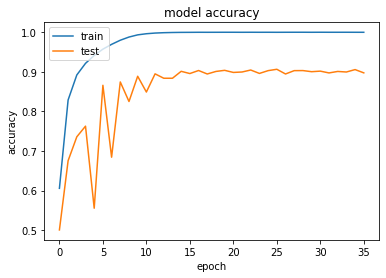

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Model Evaluation Environment


The following function loads the available images for evaluation

In [13]:
test_path = dataset_root_path + test

In [14]:
all_files = glob(test_path + '/*/*.png')

num_test = len(all_files)

evaluation_steps = int(num_test / batch_size)

print('Evaluation steps: ' + str(evaluation_steps))

Evaluation steps: 62


In [15]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
evaluation_generator = image_data_generator.flow_from_directory(test_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale')

Found 8000 images belonging to 2 classes.


## Model Evaluation

In [16]:
#from tensorflow.keras.models import load_model

In [17]:
model = tf.keras.models.load_model(model_file)

In [18]:
_, test_accuracy = model.evaluate(evaluation_generator, steps=evaluation_steps)

62/62 [==============================] - 28s 452ms/step - loss: 0.6730 - accuracy: 0.9376


In [19]:
print('Test accuracy: ' + str(round(test_accuracy * 100., 1)) + ' %')

Test accuracy: 93.8 %
